# Final Project

#### ``Objectives``


#### ``Motivation``

#### ``Data``

---
### Step 1: Import libraries

In [25]:
# standard
import os
import numpy as np
import pandas as pd

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import utils as sk_utils
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score, roc_auc_score

# plots
import seaborn as sns
import matplotlib.pyplot as plt

---
### Step 2: Data ingestion

In [2]:
# Define paths containing the images
data_dir = "data"
fake_dir = os.path.join(data_dir, "fake")
real_dir = os.path.join(data_dir, "real")

def get_dataset(fake_dir, real_dir, balance=False):
    fake_images = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir)]
    real_images = [os.path.join(real_dir, f) for f in os.listdir(real_dir)]

    if balance:
        """Truncates each class to the minimum count"""
        min_images = min(len(fake_images), len(real_images))
        fake_images = fake_images[:min_images]
        real_images = real_images[:min_images]

    image_paths = fake_images + real_images
    labels = ["fake"] * len(fake_images) + ["real"] * len(real_images)
    return image_paths, labels

def split_indices(indices, split_ratio):
    train = int(split_ratio[0] * len(indices))
    val = int(split_ratio[1] * len(indices))

    train_idx = indices[:train]
    val_idx = indices[train : train + val]
    test_idx = indices[train + val :]
    return train_idx, val_idx, test_idx

def split_data(image_paths, labels, split_ratio, seed=42, balance=False):
    image_paths, labels = np.array(image_paths), np.array(labels)

    np.random.seed(seed)

    if not balance:
        idx = np.arange(len(image_paths))
        np.random.shuffle(idx)
        train_idx, val_idx, test_idx = split_indices(idx, split_ratio)

    else:
        """Balance class by class"""
        fake_idx = np.where(labels == "fake")[0]
        real_idx = np.where(labels == "real")[0]

        np.random.shuffle(fake_idx)
        np.random.shuffle(real_idx)

        fake_train, fake_val, fake_test = split_indices(fake_idx, split_ratio)
        real_train, real_val, real_test = split_indices(real_idx, split_ratio)

        train_idx = np.concatenate([fake_train, real_train])
        val_idx = np.concatenate([fake_val, real_val])
        test_idx = np.concatenate([fake_test, real_test])

        np.random.shuffle(train_idx)
        np.random.shuffle(val_idx)
        np.random.shuffle(test_idx)

    return (
        (image_paths[train_idx], labels[train_idx]),
        (image_paths[val_idx], labels[val_idx]),
        (image_paths[test_idx], labels[test_idx]),
    )

def print_dataset(name, labels_array):
    print(f"{name} Dataset: {len(labels_array)}")
    print(f"fake: {np.sum(labels_array == 'fake')}")
    print(f"real: {np.sum(labels_array == 'real')}")

image_paths, labels = get_dataset(fake_dir, real_dir, balance=True)
(train_x, train_y), (val_x, val_y), (test_x, test_y) = split_data(
    image_paths, labels, split_ratio=[0.6, 0.2, 0.2], balance=True
)

print_dataset("Train", train_y)
print_dataset("Validation", val_y)
print_dataset("Test", test_y)
print_dataset("Full", np.concatenate([train_y, val_y, test_y]))

Train Dataset: 706
fake: 353
real: 353
Validation Dataset: 234
fake: 117
real: 117
Test Dataset: 238
fake: 119
real: 119
Full Dataset: 1178
fake: 589
real: 589


---
### Step 3: Exploratory Data Analysis (EDA)

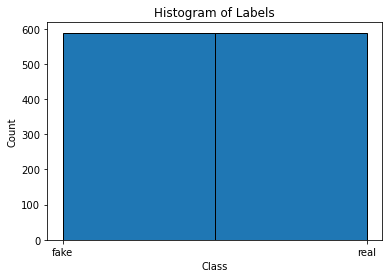

In [3]:
plt.hist(labels, bins=len(set(labels)), edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Histogram of Labels')
plt.show()

In [4]:
# load images
images = []

for path in image_paths:
    img = load_img(path)
    images.append(img)

real_ind = [i for i, x in enumerate(labels) if x == "real"]
fake_ind = [i for i, x in enumerate(labels) if x == "fake"]

real_images = [images[i] for i in real_ind]
fake_images = [images[i] for i in fake_ind]

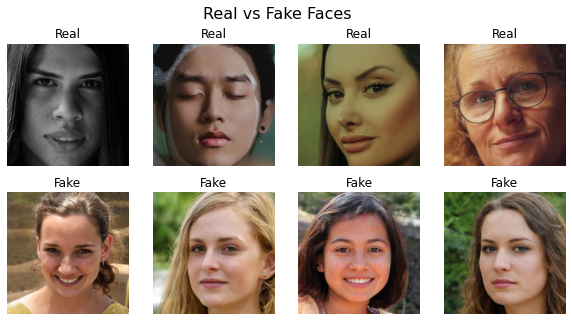

In [5]:
# Show real and fake faces
plt.figure(figsize=(10, 5))

# Show 4 real faces
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(real_images[i])
    plt.axis('off')
    plt.title("Real")

# Show 4 fake faces
for i in range(4):
    plt.subplot(2, 4, 4 + i + 1)
    plt.imshow(fake_images[i])
    plt.axis('off')
    plt.title("Fake")

plt.suptitle("Real vs Fake Faces", fontsize=16)
plt.show()

/tmp/ipykernel_4457/3906381052.py:2: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  avg_pixels_real = [np.mean(img) for img in np.array(real_images)]
/tmp/ipykernel_4457/3906381052.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_pixels_real = [np.mean(img) for img in np.array(real_images)]
/tmp/ipykernel_4457/3906381052.py:3: FutureWarning: The 

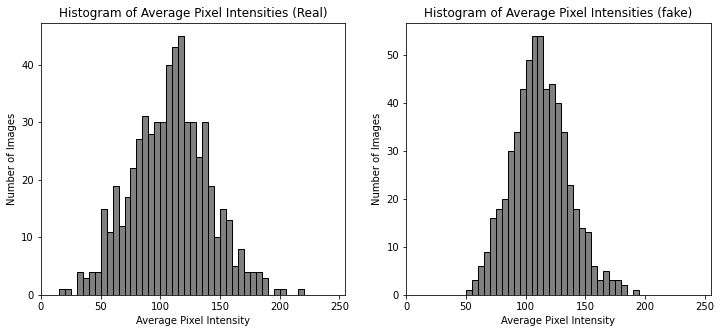

In [6]:
# Avg pixel intesity
avg_pixels_real = [np.mean(img) for img in np.array(real_images)]
avg_pixels_fake = [np.mean(img) for img in np.array(fake_images)]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Real
axs[0].hist(avg_pixels_real, range(0, 256+5, 5), color='gray', edgecolor='black')
axs[0].set_xlabel('Average Pixel Intensity')
axs[0].set_ylabel('Number of Images')
axs[0].set_title('Histogram of Average Pixel Intensities (Real)')
axs[0].set_xlim(0, 255)

# Fake
axs[1].hist(avg_pixels_fake, range(0, 256+5, 5), color='gray', edgecolor='black')
axs[1].set_xlabel('Average Pixel Intensity')
axs[1].set_ylabel('Number of Images')
axs[1].set_title('Histogram of Average Pixel Intensities (fake)')
axs[1].set_xlim(0, 255)

plt.show()

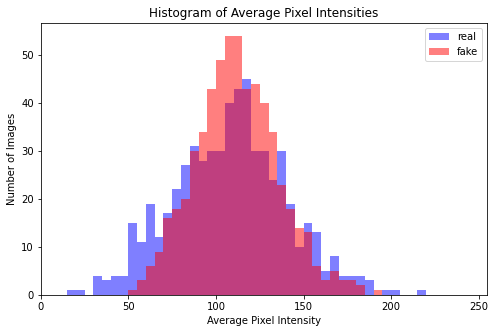

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(avg_pixels_real, bins=range(0, 256+5, 5), label='real', color='blue', alpha=0.5)
ax.hist(avg_pixels_fake, bins=range(0, 256+5, 5), label='fake', color='red', alpha=0.5)
ax.set_title("Histogram of Average Pixel Intensities")
ax.set_xlabel("Average Pixel Intensity")
ax.set_ylabel("Number of Images")
ax.set_xlim(0,255)
ax.legend()

plt.show()

/tmp/ipykernel_4457/594569194.py:3: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  avg_per_channel_real = [np.array(img).mean(axis=(0, 1)) for img in np.array(real_images)]
/tmp/ipykernel_4457/594569194.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_per_channel_real = [np.array(img).mean(axis=(0, 1)) for img in np.array(real_images)]
/tmp/ipyke

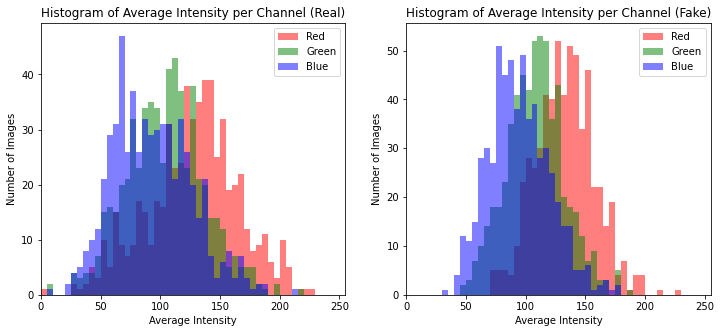

In [8]:
# Average Per channel (RGB)

avg_per_channel_real = [np.array(img).mean(axis=(0, 1)) for img in np.array(real_images)]
avg_per_channel_fake = [np.array(img).mean(axis=(0, 1)) for img in np.array(fake_images)]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist([arr[0] for arr in avg_per_channel_real], bins=range(0, 256+5, 5), color='red', alpha=0.5, label='Red')
axs[0].hist([arr[1] for arr in avg_per_channel_real], bins=range(0, 256+5, 5), color='green', alpha=0.5, label='Green')
axs[0].hist([arr[2] for arr in avg_per_channel_real], bins=range(0, 256+5, 5), color='blue', alpha=0.5, label='Blue')
axs[0].set_title("Histogram of Average Intensity per Channel (Real)")
axs[0].set_xlabel("Average Intensity")
axs[0].set_ylabel("Number of Images")
axs[0].set_xlim(0,255)
axs[0].legend()

axs[1].hist([arr[0] for arr in avg_per_channel_fake], bins=range(0, 256+5, 5), color='red', alpha=0.5, label='Red')
axs[1].hist([arr[1] for arr in avg_per_channel_fake], bins=range(0, 256+5, 5), color='green', alpha=0.5, label='Green')
axs[1].hist([arr[2] for arr in avg_per_channel_fake], bins=range(0, 256+5, 5), color='blue', alpha=0.5, label='Blue')
axs[1].set_title("Histogram of Average Intensity per Channel (Fake)")
axs[1].set_xlabel("Average Intensity")
axs[1].set_ylabel("Number of Images")
axs[1].set_xlim(0,255)
axs[1].legend()
plt.show()

---
### Step 4: Data preprocessing

In [9]:
train_df = pd.DataFrame({"image_path": train_x, "label": train_y})
val_df = pd.DataFrame({"image_path": val_x, "label": val_y})
test_df = pd.DataFrame({"image_path": test_x, "label": test_y})

# Image properties
img_height, img_width = 300, 300
batch_size = 32

# Data augmentation and loading
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_set = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
)

val_set = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image_path",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
)

test_set = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False,
)

Found 706 validated image filenames belonging to 2 classes.
Found 234 validated image filenames belonging to 2 classes.
Found 238 validated image filenames belonging to 2 classes.


---
### Step 5: Modeling

In [10]:
# Define a custom early stopping class
# Early stopping callback: stops training when both train and validation accuracy are high enough
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        stop_acc = 0.9
        train_acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")
        if train_acc >= stop_acc and val_acc >= stop_acc:
            print(
                f"\nStopping early at epoch {epoch + 1} - train accuracy: {train_acc:.4f}, validation accuracy: {val_acc:.4f}"
            )
            self.model.stop_training = True

In [11]:
# Baseline FFNN Model
baseline_model = Sequential()

baseline_model.add(Flatten())
baseline_model.add(Dense(units=128, activation="relu"))
baseline_model.add(Dense(units=128, activation="relu"))
baseline_model.add(Dense(units=1, activation="sigmoid"))

# Compile the model
learning_rate = 0.0001
baseline_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Train the model
max_epochs = 50
history = baseline_model.fit(
    train_set,
    validation_data=val_set,
    epochs=max_epochs,
    callbacks=[CustomEarlyStopping()],
)

2025-04-14 19:40:47.017810: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/opt/conda/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2025-04-14 19:40:48.644501: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138240000 exceeds 10% of free system memory.
2025-04-14 19:40:48.718617: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138240000 exceeds 10% of free system memory.
2025-04-14 19:40:48.982035: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138240000 exceeds 10% of free system memory.
2025-04-14 19:40:49.059325: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138240000 exceeds 10% of free system memory.
2025-04-14 19:40:49.157227: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138240000 exceeds 10% of free system memory.


23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 726ms/step - accuracy: 0.5033 - loss: 2.1973 - val_accuracy: 0.7479 - val_loss: 0.5008
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 759ms/step - accuracy: 0.5165 - loss: 1.7234 - val_accuracy: 0.5684 - val_loss: 1.3250
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 730ms/step - accuracy: 0.6065 - loss: 1.2972 - val_accuracy: 0.5940 - val_loss: 0.9408
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 731ms/step - accuracy: 0.6552 - loss: 0.6835 - val_accuracy: 0.5983 - val_loss: 0.6832
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 715ms/step - accuracy: 0.6718 - loss: 0.6387 - val_accuracy: 0.5897 - val_loss: 0.7364
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 741ms/step - accuracy: 0.6125 - loss: 0.8183 - val_accuracy: 0.6838 - val_loss: 0.5773
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 736ms/step - accuracy: 0.6489 - loss: 0.6649 - val_accuracy: 0.5855 - val_loss: 0.8739
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 763ms/step - accuracy: 0.6208 - loss: 0.8244 - val_accuracy: 0.722

In [12]:
# Define the CNN
model = Sequential()

model.add(
    Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation="relu",
        input_shape=(img_height, img_width, 3),
    )
)
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(rate=0.5))

model.add(Dense(units=1, activation="sigmoid"))  # Binary classification

# Compile the model
learning_rate = 0.0001
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Train the model
max_epochs = 50
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=max_epochs,
    callbacks=[CustomEarlyStopping()],
)

/opt/conda/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.5508 - loss: 0.6925 - val_accuracy: 0.6581 - val_loss: 0.6249
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.6107 - loss: 0.6653 - val_accuracy: 0.7735 - val_loss: 0.5447
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.7208 - loss: 0.5705 - val_accuracy: 0.8462 - val_loss: 0.4960
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.7640 - loss: 0.5149 - val_accuracy: 0.8462 - val_loss: 0.4271
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.7384 - loss: 0.5161 - val_accuracy: 0.8547 - val_loss: 0.4299
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.7412 - loss: 0.5202 - val_accuracy: 0.8803 - val_loss: 0.3777
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.7495 - loss: 0.4685 - val_accuracy: 0.8718 - val_loss: 0.3635
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.8139 - loss: 0.4197 - val_accuracy: 0.8718 - val_loss:

---
### Step 6: Evaluation

In [13]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 813ms/step - accuracy: 0.9577 - loss: 0.1441
Test Accuracy: 0.9412


Evaluation plots:

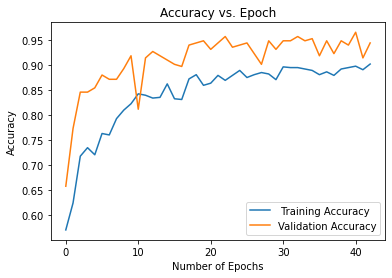

In [14]:
# Plotting accuracy vs epochs 
plt.title('Accuracy vs. Epoch')
plt.plot(history.history['accuracy'], label=' Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [15]:
# Predicting test values
pred_prob_y = model.predict(test_set)
pred_y = pred_prob_y[:,0] > 0.5
true_y = test_set.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 828ms/step


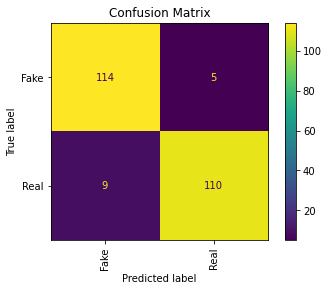

In [16]:
# Confusion matrix calculation
cm = confusion_matrix(true_y, pred_y)

# Confusion matrix plot
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['Fake', 'Real']) # 0 = fake, 1 = real
cm_plot.plot()
plt.grid(False)
plt.xticks(rotation=90)
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Calculating overall false pos, false neg, true pos, true neg
TN = cm[0,0]
TP = cm[1,1]

FP = cm[0,1]
FN = cm[1,0]

TP_rate = TP/(TP+FN) # prob. that an actual positive will test positive
TN_rate = TN/(TN+FP) # prob. that an actual negative will test negative
FP_rate = FP/(FP+TN) # prob. that an actual negative will test positive
FN_rate = FN/(FN+TP) # prob. that an actual positive will test negative

# Printing values
print(f'True positive rate: {TP_rate}')
print(f'True negative rate: {TN_rate}')
print(f'False positive rate: {FP_rate}')
print(f'False negative rate: {FN_rate}')

True positive rate: 0.9243697478991597
True negative rate: 0.957983193277311
False positive rate: 0.04201680672268908
False negative rate: 0.07563025210084033


In [18]:
# calculating overall precision and recall

final_precision = TP/(TP+FP) # prob. that an predicted positive will actually be positive
final_recall = TP/(TP+FN) # prob. that an actual positive will be predicted as positive

# Printing values
print(f'Final precision: {final_precision}')
print(f'Final recall: {final_recall}')

Final precision: 0.9565217391304348
Final recall: 0.9243697478991597


In [22]:
f1 = f1_score(true_y, pred_y, average='binary')
# same as 2*(final_precision*final_recall)/(final_precision+final_recall)
print(f'F1 Score: {f1}')

F1 Score: 0.9401709401709402


In [28]:
auc = roc_auc_score(true_y, pred_prob_y)
print(f'AUROC: {auc}')

AUROC: 0.9826989619377163


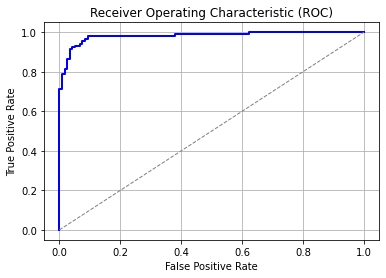

In [19]:
# Plot ROC curve

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_y, pred_prob_y)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.grid(True)
plt.show()

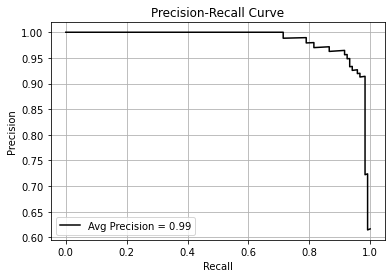

In [20]:
# Plot precision / recall curve

# Calculating
precision, recall, thresholds = precision_recall_curve(true_y, pred_prob_y)
avg_precision = average_precision_score(true_y, pred_prob_y)

# Ploting precision-recall curve
plt.figure()
plt.plot(recall, precision, c='black', label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()